In [1]:
import math
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from solve_bvp import StabilityEvalEnv

In [2]:
g = -10
rho = 10
l = 3
B = 1
lg = (-B / (g * rho)) ** (1 / 3)

In [3]:
# def fun(x, y, p):
#     """Return dy/dx"""
#     l = p[0]
#     dy1_dx = y[1]
#     dy2_dx = (rho*g*(l**3)*x*np.cos(y[0]))/(B+c)
#     dy_dx = np.vstack((dy1_dx, dy2_dx))
#     return dy_dx

# def bc(ya, yb, p):
#     """
#     Boundary residuals.
#     """
#     res1 = ya[0]
#     res2 = yb[0] - np.pi/2
#     res3 = yb[1]
#     residuals = np.array([res1, res2, res3])
#     return residuals

# # initial guesses
# x = np.linspace(0, 1, 50)
# y = np.zeros((2, x.size))
# y[0, 0] = 0
# y[0, -1] = np.pi/2
# y[1, -1] = 0
# sol = si.solve_bvp(fun, bc, x, y, [l])
# x = si.cumtrapz(sol.p[0]*np.cos(sol.y[0]), sol.x)
# y = si.cumtrapz(sol.p[0]*np.sin(sol.y[0]), sol.x)
# x -= x[0]
# y -= y[0]

In [47]:
g = -10
rho = 0.1
l = 3
B = 1
lg = (-B / (g * rho)) ** (1 / 3)
cs = np.linspace(0, 10 * B, 50)
cost = []
ls = []
alpha = 0.9

for c in cs:

    def fun(x, y, p):
        """Return dy/dx"""
        l = p[0]
        # c = p[1]
        dy1_dx = y[1]
        dy2_dx = (rho * g * (l ** 3) * x * np.cos(y[0])) / (B + c)
        dy_dx = np.vstack((dy1_dx, dy2_dx))
        return dy_dx

    def bc(ya, yb, p):
        """
        Boundary residuals.
        """
        res1 = ya[0]
        res2 = yb[0] - np.pi / 2
        res3 = yb[1]
        # res4 = yb[0]
        residuals = np.array([res1, res2, res3])
        return residuals

    x = np.linspace(0, 1, 50)
    y = np.zeros((2, x.size))
    y[0, 0] = 0
    y[0, -1] = np.pi / 2
    y[1, -1] = 0
    sol = si.solve_bvp(fun, bc, x, y, [l])
    x = si.cumtrapz(sol.p[0] * np.cos(sol.y[0]), sol.x)
    y = si.cumtrapz(sol.p[0] * np.sin(sol.y[0]), sol.x)
    x -= x[0]
    y -= y[0]
    l = sol.p[0]
    # c = sol.p[1]
    height = y[-1]
    work_int = si.trapz(sol.y[1] ** 2, sol.x)
    J = -alpha * height / l + (1 - alpha) * c / (2 * B) * work_int
    # cost[i] = J
    # print(J)
    # print(l)

    if sol.status == 0:
        cost.append((c, J))
        ls.append(sol.p[0])

    if sol.status != 0:
        print("didn't converge")
    # del sol, x, y, l

In [48]:
good_cs = [tup[0] for tup in cost]
costs = [tup[1] for tup in cost]

In [50]:
# plt.plot(good_cs, costs)
# plt.xlabel("c")
# plt.ylabel("cost")
# plt.title("Cost as a function of c")
# plt.show()

In [51]:
# plt.plot(good_cs, np.array(ls)/lg)

In [80]:
g = -9.8
rho = 1
l = 3

In [137]:
bs = np.linspace(0.1, 1, 5)
lgs = (-bs / (g * rho)) ** (1 / 3)
L = 1.5e3 * np.amax(lg)
M = 200
alpha = 0.9

In [141]:
def run_sim(b, c, l=3):
    def fun(x, y, p):
        """Return dy/dx"""
        l = p[0]
        dy1_dx = y[1]
        dy2_dx = (rho * g * (l ** 3) * x * np.cos(y[0])) / (b + c)
        dy_dx = np.vstack((dy1_dx, dy2_dx))
        return dy_dx

    def bc(ya, yb, p):
        """
        Boundary residuals.
        """
        res1 = ya[0]
        res2 = yb[0] - np.pi / 2
        res3 = yb[1]
        residuals = np.array([res1, res2, res3])
        return residuals

    # initialize
    x = np.linspace(0, 1, 50)
    y = np.zeros((2, x.size))
    y[0, 0] = 0
    y[0, -1] = np.pi / 2
    y[1, -1] = 0

    # solve
    sol = si.solve_bvp(fun, bc, x, y, [l])
    x = si.cumtrapz(sol.p[0] * np.cos(sol.y[0]), sol.x)
    y = si.cumtrapz(sol.p[0] * np.sin(sol.y[0]), sol.x)
    x -= x[0]
    y -= y[0]
    l = sol.p[0]
    return sol, x, y

In [145]:
bests_list = []  # (b, lg, j*, l*) tuples
for b in bs:
    for lg in lgs:
        cs = np.linspace(b / 10, 10 * b, 10)
        cost_list = []
        l_list = []
        active_mag_list = []
        for c in cs:
            sol, x, y = run_sim(b, c, l=1)

            # check constraints and convergence
            c0 = sol.status == 0
            c1 = sol.p[0] < L
            c2 = sol.y[1][0] > 0
            c3 = np.all((b + c) * sol.y[1] < M)

            # if constraints satisfied, compute cost and add to list
            if c0 and c1 and c2 and c3:
                height = y[-1]
                work_int = si.trapz(sol.y[1] ** 2, sol.x)
                J = -alpha * height / l + (1 - alpha) * c / (2 * b) * work_int
                cost_list.append(J)
                l_list.append(sol.p[0])
                active_mag_list.append(c)

        try:
            min_cost_arg = np.argmin(cost_list)
            min_cost = cost_list[min_cost_arg]
            l_star = l_list[min_cost_arg]
            c_star = active_mag_list[min_cost_arg]
        except:
            min_cost = 1e6
            l_star = 1e6

        bests_list.append(
            (
                round(b, 3),
                round(lg, 3),
                round(min_cost, 3),
                round(l_star, 3),
                round(c_star, 3),
            )
        )

In [146]:
bests_list

[(0.1, 0.217, 0.073, 3.294, 0.01),
 (0.1, 0.321, 0.073, 3.294, 0.01),
 (0.1, 0.383, 0.073, 3.294, 0.01),
 (0.1, 0.429, 0.073, 3.294, 0.01),
 (0.1, 0.467, 0.073, 3.294, 0.01),
 (0.325, 0.217, 0.066, 4.881, 0.032),
 (0.325, 0.321, 0.066, 4.881, 0.032),
 (0.325, 0.383, 0.066, 4.881, 0.032),
 (0.325, 0.429, 0.066, 4.881, 0.032),
 (0.325, 0.467, 0.066, 4.881, 0.032),
 (0.55, 0.217, 0.062, 5.817, 0.055),
 (0.55, 0.321, 0.062, 5.817, 0.055),
 (0.55, 0.383, 0.062, 5.817, 0.055),
 (0.55, 0.429, 0.062, 5.817, 0.055),
 (0.55, 0.467, 0.062, 5.817, 0.055),
 (0.775, 0.217, 0.059, 6.508, 0.078),
 (0.775, 0.321, 0.059, 6.508, 0.078),
 (0.775, 0.383, 0.059, 6.508, 0.078),
 (0.775, 0.429, 0.059, 6.508, 0.078),
 (0.775, 0.467, 0.059, 6.508, 0.078),
 (1.0, 0.217, 0.057, 7.085, 0.1),
 (1.0, 0.321, 0.057, 7.085, 0.1),
 (1.0, 0.383, 0.057, 7.085, 0.1),
 (1.0, 0.429, 0.057, 7.085, 0.1),
 (1.0, 0.467, 0.057, 7.085, 0.1)]

In [123]:
sol, xx, yy = run_sim(0.1, 0.217)

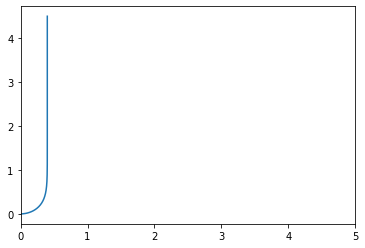

In [127]:
plt.plot(xx, yy)
plt.xlim([0, 5])
plt.show()

In [7]:
class Snake:
    def __init__(self, B, c, l, rho, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.rho = rho
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((2, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        self.y[0, 0] = 0
        self.y[0, -1] = np.pi / 2
        self.y[1, -1] = 0

    def fun_k_param(self, x, y, p):
        l = p[0]
        dy0_dx = y[1]
        dy1_dx = (self.rho * self.g * (self.l ** 3) * x * np.cos(y[0])) / (
            self.B + self.c
        )
        dy_dx = np.vstack((dy0_dx, dy1_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        """
        Boundary residuals.
        """
        l = p[0]
        res1 = ya[0]
        res2 = yb[0] - np.pi / 2
        res3 = yb[1]
        residuals = np.array([res1, res2, res3])
        return residuals

    def solve(self):
        self.sol = si.solve_bvp(self.fun_k_param, self.bc, self.x, self.y, p=[self.l])
        self.l = self.sol.p[0]
        self.x = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x)
        self.y = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x)
        self.x -= self.x[0]
        self.y -= self.y[0]